In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pymongo import MongoClient
import psycopg2
from pprint import pprint

sns.set_theme(style="dark")

In [3]:
# Database connections
mongoClient = MongoClient("localhost", 27017)
postgresConn = psycopg2.connect("dbname=ium_tweb user=postgres password=7777777")

In [4]:
# Mongo tables
soccerDb = mongoClient.soccer
soccerDb.list_collection_names()

['club_games',
 'game_lineups',
 'appearances',
 'player_valuations',
 'game_events',
 'chat',
 'games']

In [5]:
# PostgreSQL tables
sqlCursor = postgresConn.cursor()
sqlCursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'")
sqlCursor.fetchall()

[('club',), ('competition',), ('game',), ('player',), ('socceruser',)]

In [68]:
# See if ther's a correlation between goals average and the market value of a player with attack role
cursor = soccerDb.appearances.aggregate([
    {
        "$match": {
            "$expr": {
                "$eq": [{ "$year": "$date" }, 2023]
            }
        }
    },
    {
        "$group": {
            "_id": "$player_id",
            "avgGoals": { "$avg": "$goals" }
        }
    },
    {
        "$project": {
            "_id": 0,
            "player_id": "$_id",
            "avgGoals": 1
        }
    },
    {
        "$sort": {"avgGoals": -1}
    }
])
avgGoalsPlayer = pd.DataFrame(list(cursor))
sqlCursor.execute("SELECT player_id, market_value_in_eur FROM player WHERE position = 'Attack'")
marketValuePlayer = pd.DataFrame(sqlCursor.fetchall())
marketValuePlayer = marketValuePlayer.rename(columns={0: "player_id", 1: "market_value"})

,market_value,avgGoals
market_value,1.000000,0.434181
avgGoals,0.434181,1.000000


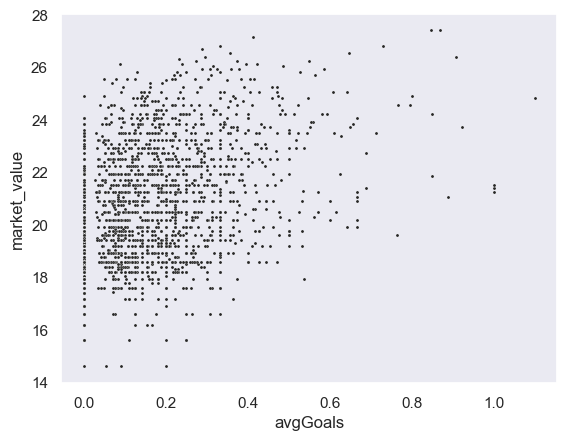

In [169]:
valueGoalPlot = pd.merge(avgGoalsPlayer, marketValuePlayer, on="player_id")
valueGoalPlot = valueGoalPlot.dropna()
valueGoalPlot['market_value'] = np.log2(valueGoalPlot['market_value'])
sns.scatterplot(x=valueGoalPlot["avgGoals"], y=valueGoalPlot["market_value"], s=5, color=".15")
valueGoalPlot[["market_value", "avgGoals"]].corr()

<BarContainer object of 15 artists>

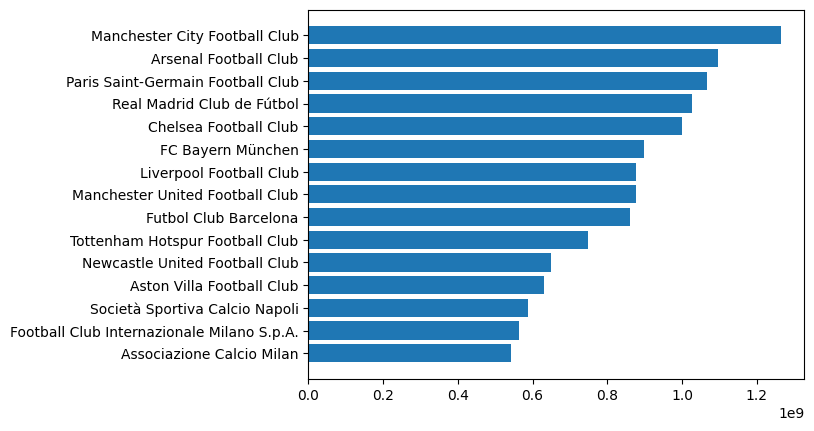

In [114]:
sqlCursor.execute("""
                    SELECT c.name, SUM(p.market_value_in_eur), count(*) FROM club AS c 
                    INNER JOIN player AS p ON c.club_id = p.current_club_id 
                    WHERE c.last_season = p.last_season
                    GROUP BY c.name
                  """)
marketValueClub = pd.DataFrame(sqlCursor.fetchall())
marketValueClub = marketValueClub.rename(columns={0: "club_name", 1: "market_value", 2: "player_count"})
marketValueClub = marketValueClub.dropna()
marketValueClub = marketValueClub.sort_values(by=["market_value"], ascending=False)
marketValueClubTop5 = marketValueClub[:15].sort_values(by=["market_value"])
plt.barh(marketValueClubTop5["club_name"], marketValueClubTop5["market_value"])

player_age    Axes(0.125,0.11;0.775x0.77)
dtype: object

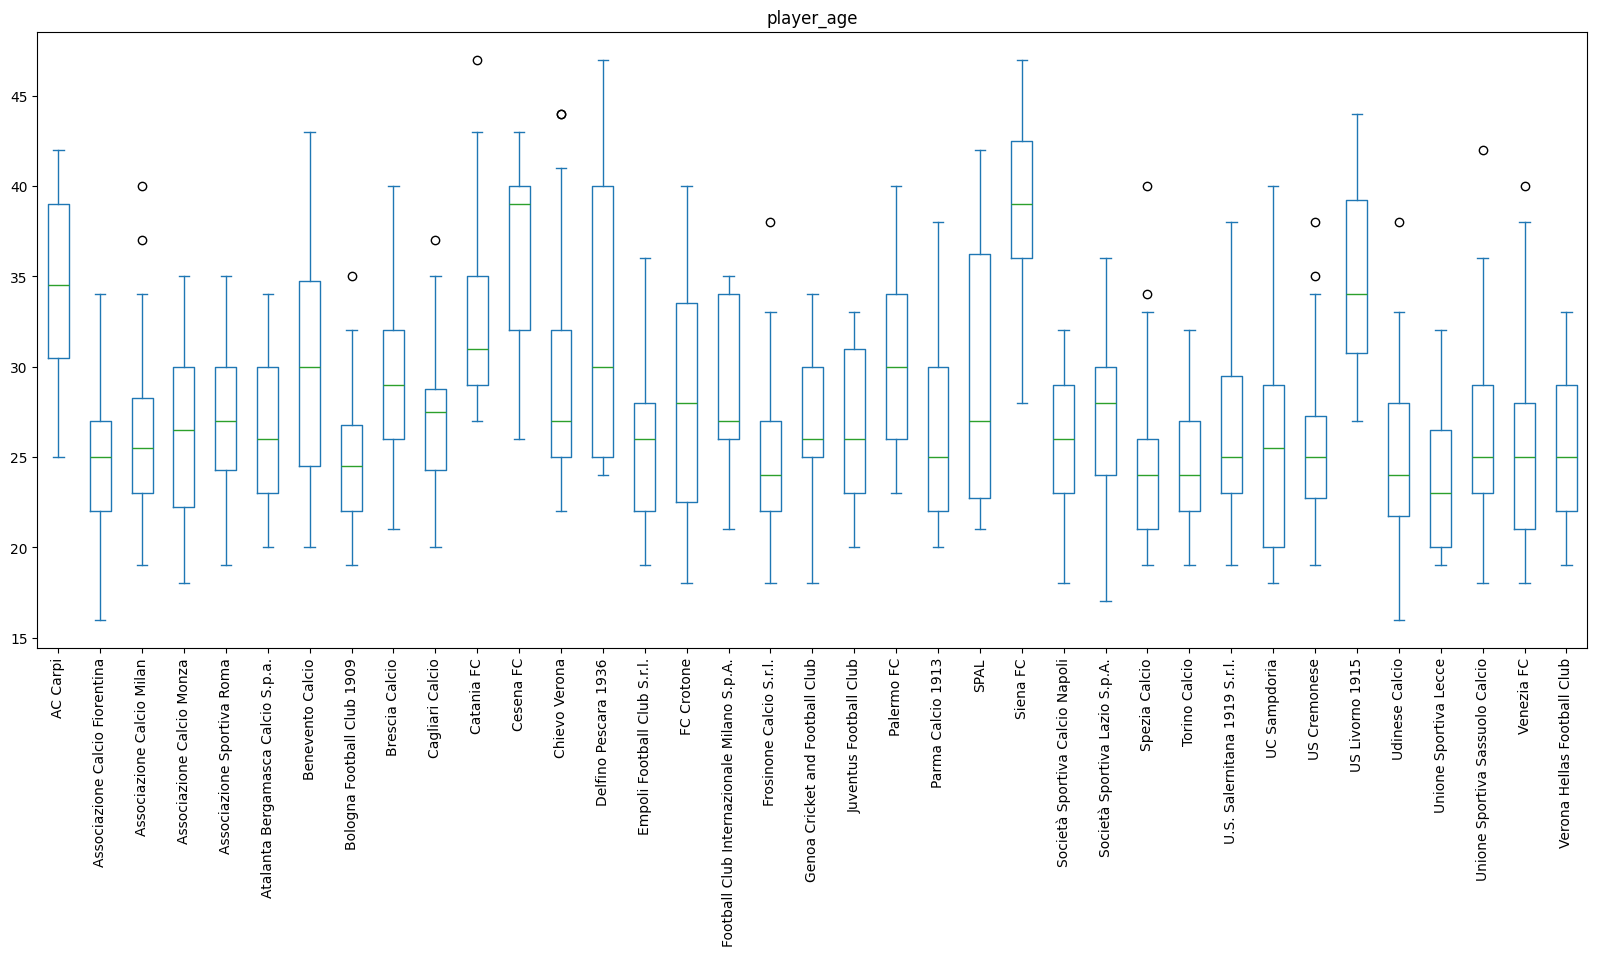

In [137]:
sqlCursor.execute("""
                  SELECT c.name, p.name, DATE_PART('year', AGE(date_of_birth)) AS age, c.domestic_competition_id FROM club AS c 
                  INNER JOIN player AS p ON c.club_id = p.current_club_id 
                  WHERE c.last_season = p.last_season
                  ORDER BY c.club_id
                  """)
agePlayerClub = pd.DataFrame(sqlCursor.fetchall())
agePlayerClub = agePlayerClub.rename(columns={0: "club_name", 1: "player_name", 2: "player_age", 3: "competition"})
agePlayerClub[agePlayerClub["competition"] == "IT1"].plot.box(column="player_age", by="club_name", figsize=(20, 8), rot=90)

,club_value,stadium_seats
club_value,1.000000,0.516532
stadium_seats,0.516532,1.000000


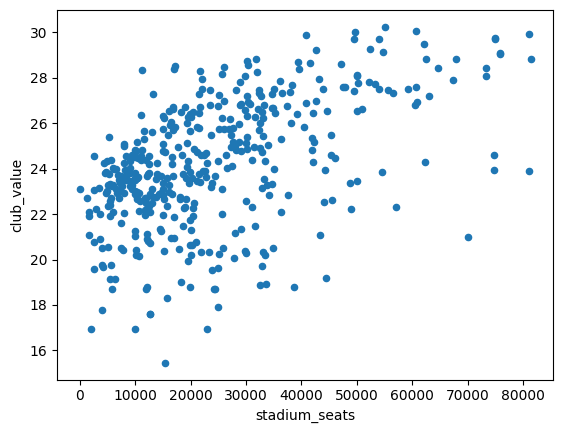

In [159]:
sqlCursor.execute("""
                    SELECT c.name, SUM(p.market_value_in_eur) AS somma, c.stadium_name, c.stadium_seats FROM club AS c 
                    INNER JOIN player AS p ON c.club_id = p.current_club_id 
                    WHERE c.last_season = p.last_season
                    GROUP BY c.name, c.stadium_name, c.stadium_seats
                    ORDER BY somma DESC
                  """)
stadiumClubValue = pd.DataFrame(sqlCursor.fetchall())
stadiumClubValue = stadiumClubValue.rename(columns={0: "club_name", 1: "club_value", 2: "stadium_name", 3: "stadium_seats"})
stadiumClubValue = stadiumClubValue.dropna()
stadiumClubValue['club_value'] = pd.to_numeric(stadiumClubValue['club_value'], errors='coerce')
stadiumClubValue['club_value'] = np.log2(stadiumClubValue['club_value'])
stadiumClubValue.plot.scatter("stadium_seats", "club_value")
stadiumClubValue[["club_value", "stadium_seats"]].corr()

<Axes: ylabel='occurrence'>

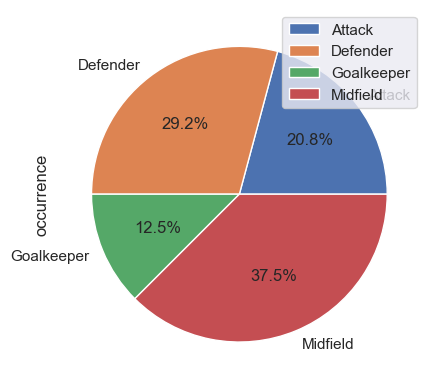

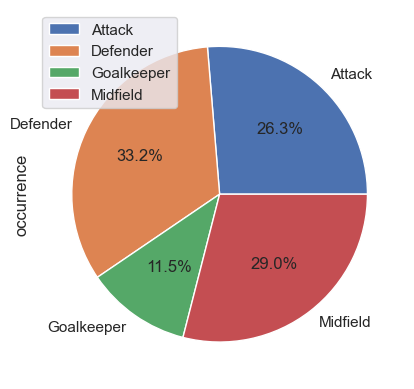

In [220]:
sqlCursor.execute("""
                    SELECT c.name, p.position, COUNT(*) FROM club AS c 
                    INNER JOIN player AS p ON c.club_id = p.current_club_id 
                    WHERE c.last_season = p.last_season
                    GROUP BY c.name, p.position
                    ORDER BY c.name
                  """)
clubComposition = pd.DataFrame(sqlCursor.fetchall())
clubComposition = clubComposition.rename(columns={0: "club_name", 1: "player_position", 2: "occurrence"})
clubComposition = clubComposition[clubComposition["player_position"] != "Missing"]

juveData = clubComposition[clubComposition["club_name"] == "Juventus Football Club"]
juveData = juveData.sort_values(by="player_position")
juveData.plot.pie(y="occurrence", labels=juveData["player_position"], autopct='%1.1f%%')

globalComposition = clubComposition[["player_position", "occurrence"]].groupby("player_position").sum().reset_index()
globalComposition = globalComposition.sort_values(by="player_position")
globalComposition.plot.pie(y="occurrence", labels=globalComposition["player_position"], autopct='%1.1f%%')

